# **TP 4 : Methode des éléments finis**

In [36]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt
import scipy.integrate as spint

L’objectif de ce TP est de programmer la méthode des éléments finis (1D) pour résoudre l’équation
elliptique avec conditions aux limites de Dirichlet:

$$
    -u"(x) + u(x) = f(x) \quad \text{pour } x \in (0,1) \\
    u(0) = u(1) = 0
$$
ou $f$ est une fonction donnée et $u$ est la solution cherchée.

## **Partie 1: (Elements finis `P1`)**

**Question 1: Definition de la `class mesh`**

In [37]:
class mesh:
    def __init__(self, Nel, xmin, xmax):
        self.Nel = Nel
        self.xmin = xmin
        self.xmax = xmax
        self.nodes = np.empty(Nel+1)
        self.h = np.empty(Nel)
        self.deg = 0
        self.dof = np.empty(self.deg*Nel+1)
        self.Ndof = self.deg*Nel+1
        
        self.degEF = 2
        self.dofEF = np.empty(self.degEF*(Nel+1), dtype=int)
        self.NdofEF = self.degEF*(Nel+1)
        
        
    """
        Question 11: ajoutons la fonction connect de la partie Partie3 (EF)
    """
    def connect(self, el, k):
        return self.degEF*el+k


    def init_uniform(self):
        # création d'un maillage uniforme
        self.nodes = np.linspace(self.xmin, self.xmax, self.Nel + 1)
        self.h = self.nodes[1:]-self.nodes[:-1]
        
    """ 
        Question 13: Ajoutons les fonctions init_randomEF et init_uniformEF de la partie Partie3 (EF)
    """ 
        
    def init_uniformEF(self):
        # création d'un maillage uniforme
        self.nodes = np.linspace(self.xmin, self.xmax, self.Nel + 1)
        self.h = self.nodes[1:]-self.nodes[:-1]
        for i in range(self.Nel + 1):
            for j in range(self.degEF):
                self.dofEF[self.degEF*i+j] = self.degEF*i+j
                
    def init_randomEF(self, Nel, xmin, xmax):
        self.Nel = Nel
        self.xmin = xmin
        self.xmax = xmax
        self.nodes = np.random.uniform(xmin, xmax, Nel + 1)
        self.nodes[0] = self.xmin
        self.nodes[-1] = self.xmax
        self.nodes = np.sort(self.nodes)
        self.h = self.nodes[1:]-self.nodes[:-1]
        for i in range(self.Nel+1):
            for j in range(self.degEF):
                self.dofEF[self.degEF*i+j] = self.degEF*i+j

    def init_random(self, Nel, xmin, xmax):
        # création d'un maillage aléatoire
        self.Nel = Nel
        self.xmin = xmin
        self.xmax = xmax
        self.nodes = np.random.uniform(xmin, xmax, Nel + 1)
        self.nodes[0] = self.xmin
        self.nodes[-1] = self.xmax
        self.nodes = np.sort(self.nodes)
        self.h = self.nodes[1:]-self.nodes[:-1]

    
    def norm_P1(self, u):
        # renvoie la norme L2 du vecteur u 
        L2_norm = 0
        H1_seminorm = 0
        # intégrale avec simpson
        for i in range(1, self.Nel-1):
            L2_norm += (u[i-1]**2 + u[i]**2) * self.h[i-1] / 2
            H1_seminorm += ((u[i] - u[i-1])**2) * \
                self.h[i-1] / self.h[i]
        return np.sqrt(L2_norm), np.sqrt(H1_seminorm)
    
    
    """
        Question 16: Ajoutons une methode norm(self, u) qui renvoie la norme L2 du vecteur u
    """
    def norm(self, u):
        L2_norm=0
        for l in range(self.Nel):
            L2_norm += (self.h[l]/6)*(u[l]**2+4*u[l+1]**2+u[l+2]**2)
            norme = np.sqrt(L2_norm)
        return norme

### Test de notre classe

In [38]:
Nel = 8
xmin = 0
xmax = 1
maillageU = mesh(Nel, xmin, xmax)
maillageR = mesh(Nel, xmin, xmax)

# maillage uniforme
maillageU.init_uniform()

# maillage aléatoire
maillageR.init_random(Nel, xmin, xmax)

# test de la classe mesh
print("Maillage uniforme : \n ", maillageU.nodes)
print("Le pas h : \n", maillageU.h)

print("Maillage random : \n ", maillageR.nodes)
print("Le pas h : \n ", maillageR.h)

Maillage uniforme : 
  [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
Le pas h : 
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Maillage random : 
  [0.         0.05516998 0.26039397 0.31730441 0.82143398 0.8565146
 0.92963969 0.94777954 1.        ]
Le pas h : 
  [0.05516998 0.20522399 0.05691044 0.50412957 0.03508062 0.07312508
 0.01813985 0.05222046]


**Question 3: Definition de la fonction `class fem`**

In [39]:
class fem:
    def __init__(self, mesh):
        self.mesh = mesh

    def matrixA_P1(self):
        # matrice de rigidité P1
        infdiag = -1/self.mesh.h[1:-1]+self.mesh.h[1:-1]/6
        supdiag = infdiag
        diag = 1/self.mesh.h[:-1] + 1/self.mesh.h[1:] + \
            self.mesh.h[:-1]/3 + self.mesh.h[1:]/3
        A = spsp.diags([infdiag, diag, supdiag], [-1, 0, 1])
        return A

    def rhs_P1(self, f):
        # second membre P1
        h = self.mesh.h
        n = self.mesh.nodes
        rhs = ((h[1:]+h[:-1])/2)*f(n[1:-1])
        return rhs

    def solve(self, f, plot=True):
        # résolution du problème P1
        A = self.matrixA_P1()
        b = self.rhs_P1(f)
        A = A.tocsc()
        u = spsplin.spsolve(A, b) # solution approchée
        if plot:
            import matplotlib.pyplot as plt
            plt.plot(self.mesh.nodes[1:-1], u) # tracé de la solution approchée
            plt.plot(self.mesh.nodes[1:-1],
                     np.sin(np.pi*self.mesh.nodes[1:-1]))  # tracé de la solution exacte
            plt.show()
        err = np.abs(np.sin(np.pi*self.mesh.nodes[1:-1])-u) 
        res = self.mesh.norm_P1(err)[0]
        return res
    
    
    """
        Question 15: Ajoutons la fonction rhs(self, f) qui renvoie le second membre
    """
    def rhs(self, f):
        b = np.zeros(self.mesh.NdofEF)
        for el in range(self.mesh.Nel):
            for ni in range(self.mesh.degEF + 1):
                i = self.mesh.connect(el, ni)
                if 0 < i <= self.mesh.NdofEF:
                    if i % 2 == 0:
                        b[i-1] += self.mesh.h[el]*f(self.mesh.dofEF[i])/6
                    else:
                        b[i-1] += 4*self.mesh.h[el]*f(self.mesh.dofEF[i])/6
        return b
    
    def MatrixA(self):
        M = np.array([[2, 1, -0.5], [1, 8, 1], [-0.5, 1, 2]]) / 15
        K = np.array([[7, -8, 1], [-8, 16, -8], [1, -8, 7]]) / 3
        A = spsp.dok_matrix((self.mesh.NdofEF, self.mesh.NdofEF))
        for el in range(self.mesh.Nel):
            for ni in range(self.mesh.degEF+1):
                i = self.mesh.connect(el, ni)
                for nj in range(self.mesh.degEF+1):
                    j = self.mesh.connect(el, nj)
                    if 0 < i <= self.mesh.NdofEF and 0 < j <= self.mesh.NdofEF:
                        A[i-1, j-1] += K[ni, nj] / self.mesh.h[el]
                        A[i-1, j-1] += M[ni, nj] * self.mesh.h[el]
        return A
    
    def  solveEF(self, f):
        A = self.MatrixA()
        A = A.tocsc()
        A.setdiag(A.diagonal() + 1e-10)
        b = self.rhs(f)
        u = spsp.linalg.spsolve(A, b)
        uexact = np.sin(np.pi*self.mesh.dofEF)
        err = np.abs(uexact-u)
        errr = self.mesh.norm(err)
        return errr, u, uexact

    
    

### Testons la classe fem

In [40]:
# on definit le maillage uniforme
maillage = mesh(1000,0,1)
maillage.init_uniform()

# on passe le maillage a la classe fem
femm = fem(maillage)


**Question 4:**

 Determinons la taille et calculons l’expression des coefficients en fonctions des tailles des éléments `(hj)` 

La fonction de base est définie comme suit :

$\varPhi_{i}(x) = \begin{cases}
  \dfrac{x - x_{i-1}}{h_{i-1}} \ , si \quad x\in \ [x_{i-1},x_i]\\
  \dfrac{x_{i+1} - x}{h_{i}} \ ,si \quad x\in \ [x_i, x_{i+1}]\\
  0 \ sinon
  \end{cases}$
    

Avec $\quad h_{i-1}= x_i - x_{i-1}\quad$ et $\quad h_{i}= x_{i+1} - x_{i}$


Et la dérivée est donnée par :
 
 $$
 \phi^{'}_{i}(x)= 
 \begin{cases}
    \frac{1}{h_{i-1}} \ x \in [x_{i-1},x_{i}] \\
    -\frac{1}{h_{i}}  \ x \in [x_{i},x_{i+1}] \\
    0 \ sinon 
  \end{cases}
$$

Déterminons les élements de la sur-diagonale :

$\varPhi_i\varPhi_{i+1}(x) = \begin{cases}
  \dfrac{(x_{i+1} - x)(x - x_i)}{h_{i}^2} \ , x \in \ [x_i, x_{i+1}]\\
  0 \ sinon
  \end{cases}$ $\quad et\quad $ $\varPhi'_i\varPhi'_{i+1}(x) = \begin{cases}
  \dfrac{ - 1}{h_{i}^2} \ , x \in \ [x_i, x_{i+1}]\\
  0 \ sinon
  \end{cases}$
Alors :

$\int_{x_i}^{x_{i+1}}(\varPhi_i\varPhi_{i+1}+ \varPhi'_i\varPhi'_{i+1})(x)dx = \dfrac{-1}{h_i} + \dfrac{h_i}{6}$ $\quad avec \quad$ $h_i = x_{i+1} - x_i$

Détermonons les élements de la sous-diagonale :

$\varPhi_i\varPhi_{i-1}(x) = \begin{cases}
  \dfrac{(x_{i} - x)(x - x_{i-1})}{h_{i-1}^2} \  ,x \in  \ [x_{i-1}, x_{i}]\\
  0 \ sinon
  \end{cases}$ $\quad et\quad $ $\varPhi'_i\varPhi'_{i-1}(x) = \begin{cases}
  \dfrac{ - 1}{h_{i-1}^2} \ , x \in \ [x_{i-1}, x_{i}]\\
  0 \ sinon
  \end{cases}$
Alors :

$\int_{x_{i-1}}^{x_{i}}(\varPhi_i\varPhi_{i-1}+ \varPhi'_i\varPhi'_{i-1})(x)dx = \dfrac{-1}{h_{i-1}} + \dfrac{h_{i-1}}{6}$ $\quad avec \quad$ $h_i = x_{i-1} - x_i$

De même on aura les élements de la diagonale 

$\int_{x_{i-1}}^{x_{i+1}}(\varPhi{_{i}^{2}}+ \varPhi'{_i^2})(x)dx = \dfrac{1}{h_{i-1}} + \dfrac{1}{h_{i}}+ \dfrac{h_{i-1}}{3} + \dfrac{h_i}{3}$


Ainsi les coefficients de la matrice sont donnés par:
  
$A_{ij} =0\ à \ si \ |i-j| > 1$

$A_{ii} = \int_{x_{i-1}}^{x_{i+1}}(\phi^{'}_{i}(x)^2 + \phi_{i}(x)^2)dx =  \frac{1}{h_{i-1}} +\frac{1}{h_{i}}+  \frac{1}{3}(h_{i-1}  + h_{i})$

$A_{i,i+1}=\int_{x_i}^{x_{i+1}} (\phi_{i}^{'}(x)\phi_{i+1}^{'}(x) + \phi_{i+1}(x)\phi_{i}(x))dx = -\frac{1}{h_i} + \frac{1}{6}h_{i}$

$A_{i-1,i}=\int_{x_{i-1}}^{x_{i}}(\phi_{i-1}^{'}(x) \phi_{i}^{'}(x)+ \phi_{i-1}(x)\phi_{i}(x))dx=-\frac{1}{h_{i-1}}+\frac{1}{6}h_{i-1}$



\begin{pmatrix}
  \ddots & \ddots &   \\
  \ddots & \ddots &  \\
  \cdots & &(-\frac{1}{h_{i-1}}+\frac{1}{6}h_{i-1}) & (\frac{1}{h_{i-1}} +\frac{1}{h_{i}}+   \frac{1}{3}(h_{i-1}  + h_{i})) & (-\frac{1}{h_{i}} + \frac{1}{6}h_{i}) & \cdots &  \\ 
         & \\ & \ddots \\
    & \\ &   & \ddots & \ddots & \ddots

\end{pmatrix}





**Question 5** :

Toujours dans cette classe, définir la fonction rhs_P1(self,f) qui prend en entrée une fonction f et qui renvoie le tableau contenant une approximation du vecteur b 


(voir classe)

**Question 6** : 

Determinons `f(x)` pour tester notre méthode

Determinons $f$ telle que $u(x) = \sin(\pi x)$ soit solution de l'équation.

On a:
$$
  u(x) = \sin(\pi x) \Rightarrow u'(x) = \pi \cos(\pi x) \Rightarrow u''(x) = -\pi^2 \sin(\pi x)
$$
Ainsi on a:
$$
  - u''(x) + u(x) = \pi^2 \sin(\pi x) + \sin(\pi x) = (\pi^2 + 1) \sin(\pi x)
$$
Et alors $f(x) = (\pi^2 + 1) \sin(\pi x)$.

In [41]:
## on la fonction f pour le second membre
def f(x):
    return (1 + np.pi**2)*np.sin(np.pi*x)


**Question 7:** 

Programmons la fonction `solve` (voir classe fem)

Definissons notre `u_exact` 

In [42]:
# definition de u_exact
def u_exact(x):
  return np.sin(np.pi*x)

Affichage de la solution exacte et la solution approchée sur le même graphique

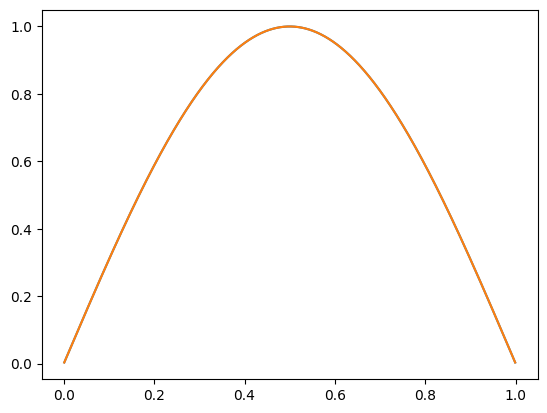

6.350636964034786e-07

In [43]:
## on cherche la solution approchee par la methode solve de la classe fem
femm.solve(f, plot=True)

## **Partie 2: (Etude)**

**Question 9:** 

Determinons l'ordre de convrgence numerique en tracant l'erreur en fonction de $h$ en echelle log-log.

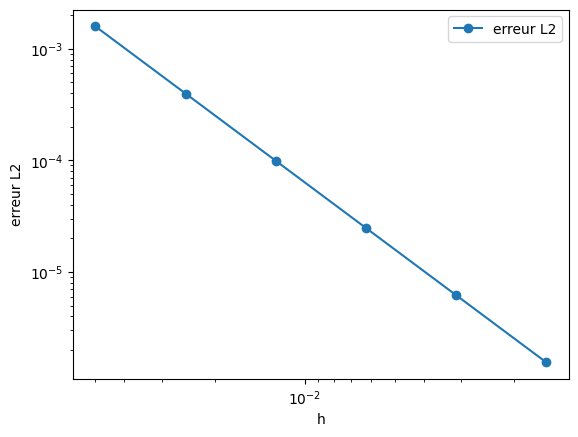

In [44]:
liste = [20,40,80,160,320,640]
h = []
err = []
for i in liste: 
    maillage = mesh(i, 0, 1)
    maillage.init_uniform()
    ef = fem(maillage)
    err.append(ef.solve(f, plot=False))
    h.append(np.max(maillage.h))
err = np.array(err)
h = np.array(h)
plt.xlabel("h")
plt.ylabel("erreur L2")
plt.gca().invert_xaxis()
plt.plot(h, err, 'o-', label="erreur L2")
plt.loglog()
plt.legend()
plt.show()

**Question 10:** 

Affichons le contionnement de la matrice pour le maillage uniforme
puis pour le maillage aléatoire pour différentes valeurs de Nel.

In [45]:
Nel_list = [10, 20, 40, 80, 160, 320, 640]
cond_list_uniform = []
cond_list_random = []

for Nel in Nel_list:
    MeshU = mesh(Nel, 0, 1)
    MeshU.init_uniform()
    femm_u = fem(MeshU)
    A_u = femm_u.matrixA_P1()
    
    cond_list_uniform.append(np.linalg.cond(A_u.todense()))
    
    MeshR = mesh(Nel, 0, 1)
    MeshR.init_random(Nel, 0, 1)
    femm_r = fem(MeshR)
    A_r = femm_r.matrixA_P1()
    cond_list_random.append(np.linalg.cond(A_r.todense()))

cond_list_uniform = np.array(cond_list_uniform)
cond_list_random = np.array(cond_list_random)

print("Maillage uniforme: \n")
print("Conditionnment: \n", cond_list_uniform)
print()
print("Maillage random: \n")
print("Conditionnment: \n", cond_list_random)

Maillage uniforme: 

Conditionnment: 
 [3.62557642e+01 1.46653325e+02 5.88251225e+02 2.35464473e+03
 9.42021923e+03 3.76825173e+04 1.50731710e+05]

Maillage random: 

Conditionnment: 
 [1.82102984e+02 9.94237380e+02 1.23726744e+05 3.73362339e+04
 7.89055934e+06 2.64024065e+07 5.80053282e+07]


On observe que plus le nombre  d'element est grand, plus le conditionnement est eleve.

## **Partie 3:** Elements finis `P2`

**Question 11:**

voir classe `mesh`

**Question 12:**

voir classe `mesh`

**Question 13:**

voir classe `mesh`

**Question 14:**

Verifions que les matrices $M=(\int_{[0,1]} \phi_k \phi_{k'} dx)_{0\leq k,k^{'} \leq deg}$ et $K = (\int_{[0,1]} \phi_k' \phi_{k'}' dx)_{0\leq k,k' \leq deg}$ sont donnees par: 

`M = np.array([[2,1,-0.5], [1,8,1], [-0.5,1,2]]) / 15` 

et 

`K = np.array([[7,-8,1], [-8,16,-8], [1,-8,7]]) / 3`

On a: 
$M=(\int_{[0,1]} \phi_i \phi_j dx)_{0\leq i,j \leq deg}$

Donc 
$$

    M_{00} = \int_{[0,1]} (2x-1)^2(x-1)^2 dx = \frac{2}{15}
$$

$$
    M_{01} = M_{10} = \int_{[0,1]} -4x(2x-1)(x-1)^2 dx = \frac{1}{15}
$$

$$
    M_{02} = M_{20}= \int_{[0,1]} x(2x-1)^2(x-1) dx = \frac{-1}{30}
$$

$$
M_{11} = \int_{[0,1]} 16x^2(1-x)^2 dx = \frac{8}{15}
$$

$$
M_{12} = M_{21} = \int_{[0,1]} 4x^2(2x-1)(1-x) dx = \frac{1}{15}
$$

$$
M_{22} = \int_{[0,1]} x^2(2x-1)^2 dx = \frac{2}{15}
$$


pareil verifionsque la matrice $K = (\int_{[0,1]} \phi_k' \phi_{k'}' dx)_{0\leq k,k' \leq deg}$ est donnee par: `np.array([[7,-8,1], [-8,16,-8], [1,-8,7]]) / 3`

on a:
$$
K_{00} = \int_{[0,1]} 8(2x -1)(x-1)dx = \frac{7}{3}
$$

$$
K_{01} = K_{10} = \int_{[0,1]} -16x(2x-1)(x-1)dx = \frac{-8}{3}
$$

$$
K_{02} = K_{20} = \int_{[0,1]} 8x(2x-1)(x-1)dx = \frac{1}{3}
$$

$$
K_{11} = \int_{[0,1]} 16x^2 dx = \frac{16}{3}
$$

$$
K_{12} = K_{21} = \int_{[0,1]} -16x^2 dx = \frac{-8}{3}
$$

$$
K_{22} = \int_{[0,1]} 8x(2x-1)dx = \frac{7}{3}
$$


**Question 15:**

Ajoutons la fonction `rhs(self,f)`  (voir classe `fem`)


**Question 16:**

Ajoutons la fonction `norm(self, u)` (voir classe `mesh`)

**Question 17:** Etude da la convergence

On definit une methode `solveEF(self)` dans la classe `fem` qui resoud le probleme avec la methode des elements finis et qui retourne l'erreur, la solution exacte et la solution approche.

In [46]:
## fONCTION DE SECOND MEMBRE
def f(x):
    return (1 + np.pi**2)*np.sin(np.pi*x)

## TEST
Mh = mesh(1000, 0, 1)
Mh.init_uniformEF()

Fem = fem(Mh)
errr, u, uexact = Fem.solveEF(f)

## Affichage des resultant
print("Solution exacte: ", uexact)
print()
print("Solution approchée: ", u)
print()
print("Erreur L2: ", errr)

Solution exacte:  [ 0.00000000e+00  1.22464680e-16 -2.44929360e-16 ...  6.36184975e-14
 -6.42833292e-13  3.12553384e-13]

Solution approchée:  [1.53507189e-16 3.07014083e-16 4.60521275e-16 ... 2.07804899e-13
 0.00000000e+00 0.00000000e+00]

Erreur L2:  1.4221589511374353e-13


Determiinons l'ordre de convergence numerique en tracant l'erreur en fonction de $h$ en echelle log-log.

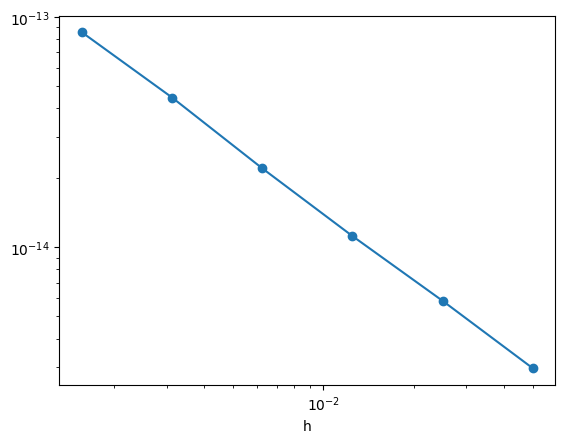

In [47]:
liste = [20,40,80,160,320,640]
h = []
err = []
for i in liste: 
    maillage = mesh(i, 0, 1)
    maillage.init_uniformEF()
    ef = fem(maillage)
    err.append(ef.solveEF(f)[0])
    h.append(np.max(maillage.h))
err = np.array(err)
h = np.array(h)
plt.xlabel("h")
plt.plot(h, err, 'o-')
plt.loglog()
plt.show()